In [1]:
# ###########################################################################
#
#  CLOUDERA APPLIED MACHINE LEARNING PROTOTYPE (AMP)
#  (C) Cloudera, Inc. 2020
#  All rights reserved.
#
#  Applicable Open Source License: Apache 2.0
#
#  NOTE: Cloudera open source products are modular software products 
#  made up of hundreds of individual components, each of which was 
#  individually copyrighted.  Each Cloudera open source product is a 
#  collective work under U.S. Copyright Law. Your license to use the 
#  collective work is as provided in your written agreement with  
#  Cloudera.  Used apart from the collective work, this file is 
#  licensed for your use pursuant to the open source license 
#  identified above.
#
#  This code is provided to you pursuant a written agreement with
#  (i) Cloudera, Inc. or (ii) a third-party authorized to distribute 
#  this code. If you do not have a written agreement with Cloudera nor 
#  with an authorized and properly licensed third party, you do not 
#  have any rights to access nor to use this code.
#
#  Absent a written agreement with Cloudera, Inc. (“Cloudera”) to the
#  contrary, A) CLOUDERA PROVIDES THIS CODE TO YOU WITHOUT WARRANTIES OF ANY
#  KIND; (B) CLOUDERA DISCLAIMS ANY AND ALL EXPRESS AND IMPLIED 
#  WARRANTIES WITH RESPECT TO THIS CODE, INCLUDING BUT NOT LIMITED TO 
#  IMPLIED WARRANTIES OF TITLE, NON-INFRINGEMENT, MERCHANTABILITY AND 
#  FITNESS FOR A PARTICULAR PURPOSE; (C) CLOUDERA IS NOT LIABLE TO YOU, 
#  AND WILL NOT DEFEND, INDEMNIFY, NOR HOLD YOU HARMLESS FOR ANY CLAIMS 
#  ARISING FROM OR RELATED TO THE CODE; AND (D)WITH RESPECT TO YOUR EXERCISE 
#  OF ANY RIGHTS GRANTED TO YOU FOR THE CODE, CLOUDERA IS NOT LIABLE FOR ANY
#  DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, PUNITIVE OR
#  CONSEQUENTIAL DAMAGES INCLUDING, BUT NOT LIMITED TO, DAMAGES 
#  RELATED TO LOST REVENUE, LOST PROFITS, LOSS OF INCOME, LOSS OF 
#  BUSINESS ADVANTAGE OR UNAVAILABILITY, OR LOSS OR CORRUPTION OF
#  DATA.
#
# ###########################################################################


# Semantic Image Search Tutorial

This repository provides automated backend build scripts and a user interface to visually explore how convolutional neural networks (CNNs) can be applied to the task of semantic image search on two distinct datasets. This notebook offers a practical implementation guide for two of the techniques underlying the front end app - feature extraction & semantic similarity search. For a more theoretical review of deep learning and image analysis, check out the full Cloudera Fast Forward Labs report [here](https://www.cloudera.com/products/fast-forward-labs-research/fast-forward-labs-research-reports.html).



### Table of Contents

1. [Overview of Semantic Similarity Search](#section1)
2. [Feature Extraction with CNN's](#section2)
3. [Similarity Search with FAISS](#section3)

## 1. Overview of Semantic Image Search
<a id='section1'></a>

Semantic image search refers to the task of *ranking a collection of images by similarity with respect to any one image in the collection*. While there are varying implementations to the task of semantic image search, the general workflow for our solution is straightforward and involves the following steps:

![Semantic Search](images/semantic_search.png)

This simple approach begins by extracting a feature map from each image in a given dataset using a pre-trained CNN (think VGG16, InceptionV3, etc.). We can then compute similarity as the distance between two of those feature maps, and repeat this distance metric calculation for every image-to-image combination in our dataset. By ranking the list of distance metrics in descending order for any given image, we obtain the most semantically similar results. Ultimately a *good* model will extract features that correctly capture semantic similarity - meaning that feature maps for similar images *are* actually close together (in vector space) and feature maps for dissimilar images are further apart.

But what exactly is a feature map? What does "semantic similarity" mean in this context? What makes a feature map semantically valuable? And how do we efficiently store all of those extracted feature vectors to enable rapid similarity measure calculations? Keep reading as we dive into the specifics.

## 2. Feature Extraction with CNN's
<a id='section2'></a>

Convolutional Neural Networks inherently function as feature extractors because by design, they condense high dimensional, spatial representations (e.g. a 2D or 3D images) into rich, lower dimensional vectors. They do this by learning layers of convolutional filters during the training phase of a network. Filters in the early layers of a CNN learn to identify low-level features (e.g. lines, edges, shapes, colours), while those in later layers learn high-level, compounded concepts (e.g eyes, legs, faces, doors).

![Feature Extraction using CNN](images/CNN_feature_extractor.png)
[Image Source](https://www.researchgate.net/figure/A-CNN-is-composed-of-two-basic-parts-of-feature-extraction-and-classification-Feature_fig1_314090304)

At inference time, a CNN takes an image as input and processes it using those learned filters. Specifically, each layer of convolutions is sequentially applied to the input signal - where the output of one layer, feeds directly as input to the next. That intermediate output of each layer *is* a feature map - a matrix of activations for each channel in that layer. Since modern CNNs have many layers, we naturally arrive at the question: Which layer's output should be extracted and used to calculate similarity? Or put another way, at what layer in the CNN does the feature map hold the most semantic value?

In practice, it depends on the task at hand. Generally speaking, the later layers will produce the best result because feature maps that are extracted from the final layer of a CNN will contain the most rich semantic representation of an input image. However, when the definition of similarity is simple (e.g. just a need for colors and edges), feature maps extracted from earlier layers can work well.

Let's further our intuition around feature maps with a concrete example.

### Load Data

First, let's load the Iconic200 dataset used in this repository.

In [2]:
import os
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from tensorflow.keras.preprocessing import image as imageprep

ICONIC_PATH = "./images/snowflakes"

def image_to_array(img_path, image_size): 

    img = imageprep.load_img(img_path, target_size=(image_size, image_size))
    img = imageprep.img_to_array(img) 
    
    return img

def load_images(image_dir, image_size):
    
    image_list = os.listdir(image_dir)
    img_holder = []
    
    for img in image_list:
        
        if '.jpg' not in img:
            continue
        
        img_path = image_dir+'/'+img
        img = image_to_array(img_path, image_size)
        img_holder.append(img)
    
    return img_holder


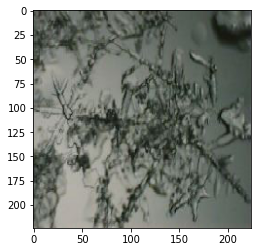

In [3]:
# Load each image, enforce image size compatibility with VGG16, and return as numpy array
iconic_imgs = load_images(ICONIC_PATH, 224)

# Let's select an example image that we'll use to analyze feature maps for
ex_img = iconic_imgs[0]
plt.imshow(ex_img/255)

### Load a Pretrained Model

Let's load up a VGG16 model architecture with weights that have been pretrained on ImageNet. The model summary provides a look at each layer and its corresponding output shape (organized into blocks).

In [4]:
# Load a pretrained VGG16 model
from tensorflow.keras.applications import vgg16
vgg16_model = vgg16.VGG16(weights='imagenet')

vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Extract a Feature Map


As mentioned above, the intermediate output between any layer in the CNN *is* a feature map. For our purposes, we want to focus on convolutional layers with trainable parameters. Lets start by extracting a feature map from the first convolutional layer output corresponding to **block1_conv1 (Conv2D)** from above. To do this, we can design a new model that is just a subset of the layers from the full VGG16 model. That is, create a new model that copies the input layer and then just use the output of the **block1_conv1** layer - which again, *is* the feature map from that layer.

In [5]:
# Define a new model to output feature map for first layer
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input

b1c1_model = Model(inputs=vgg16_model.inputs, outputs=vgg16_model.get_layer('block1_conv1').output)

In [6]:
# Add dimension and preprocess to scale pixel values for VGG
ex_img = np.expand_dims(ex_img, axis=0)
ex_img = preprocess_input(ex_img)

# Get feature map
b1c1_feature_map = b1c1_model.predict(ex_img)

# Validate dimensions
b1c1_feature_map.shape

(1, 224, 224, 64)

### Visualize Feature Map

As expected, we see that the feature map generated from the output of the first layer of VGG16 *does* conform to the expected shape seen in the model summary. The first convolutional layer of VGG16 applies 64 3x3 filters resulting in 64 channels (or 64 feature maps / activation maps). We can visualize each of these activation maps to gain intuition for the types of things that the learned filters are detecting as signal at this layer.

In the example below, we see that some channels are picking up on lines/edges/contrast changes, while others focus on background and foreground shading/color. This is consistent with our expectation as this first layer should be honing in on very specific details in the image.  

In [7]:
def plot_feature_map(feature_map, max_grid):
    
    fig, ax = plt.subplots(max_grid, max_grid, figsize=(7,7))
    channel_idx = 0
    
    for i in range(max_grid):
        for j in range(max_grid):
            ax[i][j].imshow(feature_map[0,:,:,channel_idx])
            ax[i][j].axis('off')
            
            channel_idx += 1
            
    fig.suptitle(f'Feature Map - Displaying {max_grid**2} of {feature_map.shape[3]} Channels')
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

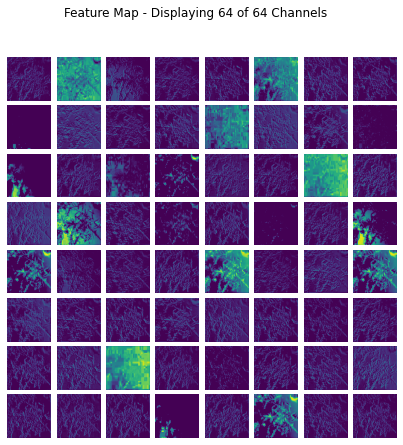

In [8]:
# Generate visualization
plot_feature_map(b1c1_feature_map, 8)

### Feature Map Comparison

To further build intuition on what semantic value is gained at different depths in the network, let's repeat this exercise with the last convolutional layer from the last block - **block5_conv3 (Conv2D)**. From the output below, we first notice that the activation map from this layer has many more channels (512 vs. 64), and that each channel is now of size 14x14 (vs. 224x224). Effectively, the CNN has teased out semantic meaning (i.e. features) from the original 224x224x3 image and condensed that semantic meaning by a third into a rich, 14x14x512 feature matrix.

We also notice that the channels themselves are not visually interpretable compared to those from the first layer. This makes sense because the later layers have compounded input signal through each layer of convolutions. The model has built up it's own abstract, generalized representations of what features it deems important.

In [9]:
# Define second model to capture output from block5_conv3
b5c3_model = Model(inputs=vgg16_model.inputs, outputs=vgg16_model.get_layer('block5_conv3').output)

# Get feature map
b5c3_feature_map = b5c3_model.predict(ex_img)

# Validate dimensions
b5c3_feature_map.shape

(1, 14, 14, 512)

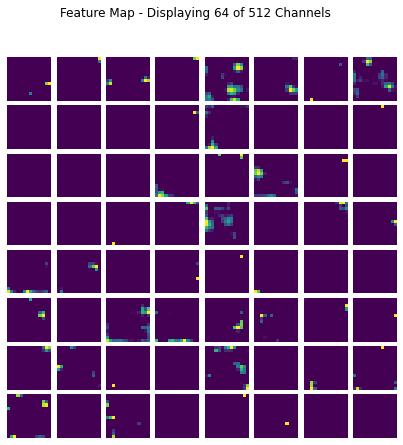

In [10]:
# Generate visualization
plot_feature_map(b5c3_feature_map, 8)

## 3. Similarity Search with FAISS
<a id='section3'></a>

Now that we understand how to extract semantically meaningful features with a pretrained CNN, we can explore how to use those features for the purpose of search in a scalable manner. *Facebook AI Similarity Search (FAISS)* is a highly optimized library that allows us to do just that - compare a query record (e.g. feature vector) against a stored database of other feature vectors to retrive those that are most similar. There are various metrics used for calculating "similarity" of two vectors, but at its simplest, similar vectors are defined as those that are nearby in Euclidean space. For more info on FAISS, check out [this article](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/).

To demonstrate FAISS in action, we'll first get feature maps from both convolution layer outputs above (block1_conv1, block5_conv3) for every image in the ICONIC200 dataset. We'll create and add all vectors from each feature map into their own FAISS index, and use those indicies for searching images against all others. Finally, we'll plot comparative similarity search results using the two feature maps for a given input image.

In [11]:
def get_feature_maps(model, image_holder):
    
    # Add dimension and preprocess to scale pixel values for VGG
    images = np.asarray(image_holder)
    images = preprocess_input(images)
    
    # Get feature maps
    feature_maps = model.predict(images)
    
    # Reshape to flatten feature tensor into feature vectors
    feature_vector = feature_maps.reshape(feature_maps.shape[0], -1)
    
    return feature_vector

In [12]:
# Extract features for all images at b5c3
all_b5c3_features = get_feature_maps(b5c3_model, iconic_imgs)

In [13]:
# Create FAISS index 
import faiss

feature_dim = all_b5c3_features.shape[1]
b5c3_index = faiss.IndexFlatL2(feature_dim)
b5c3_index.add(all_b5c3_features)

In [14]:
# Define function that uses index to retrieve the 2nd most similar vector (because these images exist within the dataset)
# I found some images that were the exact same, in which case we will retrieve the 3rd most similar
def get_most_similar(index, query_vec):
    distances, indices = index.search(query_vec, 2)
    if distances[0][1] > 0:
        return distances[0][1], indices[0][1]
    else:
        distances, indices = index.search(query_vec, 3)
        return distances[0][2], indices[0][2]

In [15]:
%%time
# Iterate through each feature vector in FAISS index and get the most similar image to that vector, store results in list
distance_list = []
for x in range(b5c3_index.ntotal):
    dist, indic = get_most_similar(b5c3_index, all_b5c3_features[x:x+1])
    distance_list.append([x, dist, indic])

CPU times: user 1min 8s, sys: 107 ms, total: 1min 8s
Wall time: 29.4 s


In [16]:
# create a data frame from the list of results
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.0f' % x)

df = pd.DataFrame(distance_list, columns = ['index', 'L2', 'similar_index'])
# df_b1c1 = df[df.layer == 'b1c1'].sort_values('L2', ascending=False)
df = df.sort_values('L2', ascending=False)

,index,L2,similar_index
442,442,5648406,314
346,346,4915508,423
377,377,4888185,371
207,207,4879182,423
351,351,4871019,339


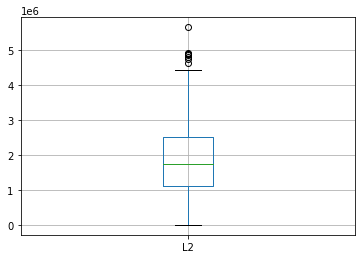

In [17]:
# examine dataframe
df.boxplot('L2')
df.head()

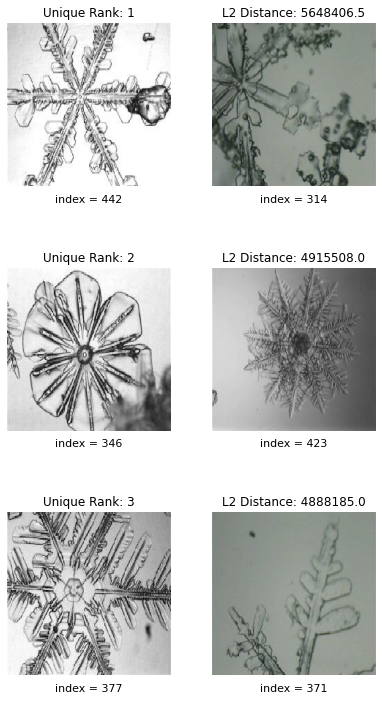

In [19]:
# create subplot
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

# iterate top 3 df rows, adding images to subplot
i = 0
for row in df.head(3).itertuples():
    # column 1
    ax[i][0].axis('off')
    ax[i][0].imshow(iconic_imgs[row.index]/255,)
    ax[i][0].set_title('Unique Rank: %s' % (i+1), fontsize=12, loc='center')
    ax[i][0].text(0.5, -0.1, 'index = %s' % row.index, size=11, ha='center', transform=ax[i][0].transAxes)
    # column 2
    ax[i][1].axis('off')
    ax[i][1].imshow(iconic_imgs[row.similar_index]/255)
    ax[i][1].set_title('L2 Distance: %s' % (row.L2), fontsize=12, loc='center')
    ax[i][1].text(0.5, -0.1, 'index = %s' % row.similar_index, size=11, ha='center', transform=ax[i][1].transAxes)
    i += 1
fig.subplots_adjust(wspace=-.56, hspace=.5)
plt.show()